In [129]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.prediction_algorithms import knns
from surprise.model_selection import train_test_split, KFold, GridSearchCV
from surprise.similarities import cosine, pearson
from surprise import accuracy
from surprise import dump
import os
from collections import defaultdict
from time import time

## Intro to problem

The goal of this project is to create a recommendation system for books. I'm using the data from the website [Goodreads](https://www.goodreads.com/), made available on [Kaggle](https://www.kaggle.com/alexanderfrosati/goodbooks-10k-updated), which consists of approximately 6 million ratings for 10,000 books, done by 53,424 unique users. Besides the ratings data, we also have access to metadata on the books, books genre and other tags, and books marked "to read" by users.


We will build a Collaboration Filtering model with surprise library experiment with a neighborhood or memory based model with a couple of different similarity metrics, as well as a Matrix Factorization-based approach.

### Load Data

We will start by loading the data that we have downloaded from the link above. Our main dataset is the ratings one, which has the basis of the data we will need to build a recommentation system. We will also load the metadata on books in order to do some exploratory analysis.

In [2]:
# load and check first entries of ratings dataset
ratings = pd.read_csv('ratings.csv')
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [3]:
# check dataset information
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 136.8 MB


In [4]:
ratings.describe()

,user_id,book_id,rating
count,5.976479e+06,5.976479e+06,5.976479e+06
mean,2.622446e+04,2.006477e+03,3.919866e+00
std,1.541323e+04,2.468499e+03,9.910868e-01
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.281300e+04,1.980000e+02,3.000000e+00
50%,2.593800e+04,8.850000e+02,4.000000e+00
75%,3.950900e+04,2.973000e+03,5.000000e+00
max,5.342400e+04,1.000000e+04,5.000000e+00


In [5]:
# check if we have any null values
ratings.isna().sum()

user_id    0
book_id    0
rating     0
dtype: int64

In [6]:
# load and check first entries of dataframe with information on books
books = pd.read_csv('books.csv')
books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [7]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    10000 non-null  int64  
 1   goodreads_book_id          10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int6

In [8]:
books.describe()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn13,original_publication_year,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
count,10000.00000,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,9.415000e+03,9979.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04
mean,5000.50000,5.264697e+06,5.471214e+06,8.646183e+06,75.712700,9.755044e+12,1981.987674,4.002191,5.400124e+04,5.968732e+04,2919.955300,1345.040600,3110.885000,11475.893800,1.996570e+04,2.378981e+04
std,2886.89568,7.575462e+06,7.827330e+06,1.175106e+07,170.470728,4.428619e+11,152.576665,0.254427,1.573700e+05,1.678038e+05,6124.378132,6635.626263,9717.123578,28546.449183,5.144736e+04,7.976889e+04
min,1.00000,1.000000e+00,1.000000e+00,8.700000e+01,1.000000,1.951703e+08,-1750.000000,2.470000,2.716000e+03,5.510000e+03,3.000000,11.000000,30.000000,323.000000,7.500000e+02,7.540000e+02
25%,2500.75000,4.627575e+04,4.791175e+04,1.008841e+06,23.000000,9.780316e+12,1990.000000,3.850000,1.356875e+04,1.543875e+04,694.000000,196.000000,656.000000,3112.000000,5.405750e+03,5.334000e+03
50%,5000.50000,3.949655e+05,4.251235e+05,2.719524e+06,40.000000,9.780452e+12,2004.000000,4.020000,2.115550e+04,2.383250e+04,1402.000000,391.000000,1163.000000,4894.000000,8.269500e+03,8.836000e+03
75%,7500.25000,9.382225e+06,9.636112e+06,1.451775e+07,67.000000,9.780831e+12,2011.000000,4.180000,4.105350e+04,4.591500e+04,2744.250000,885.000000,2353.250000,9287.000000,1.602350e+04,1.730450e+04
max,10000.00000,3.328864e+07,3.553423e+07,5.639960e+07,3455.000000,9.790008e+12,2017.000000,4.820000,4.780653e+06,4.942365e+06,155254.000000,456191.000000,436802.000000,793319.000000,1.481305e+06,3.011543e+06


In [9]:
books.isna().sum()

book_id                         0
goodreads_book_id               0
best_book_id                    0
work_id                         0
books_count                     0
isbn                          700
isbn13                        585
authors                         0
original_publication_year      21
original_title                585
title                           0
language_code                1084
average_rating                  0
ratings_count                   0
work_ratings_count              0
work_text_reviews_count         0
ratings_1                       0
ratings_2                       0
ratings_3                       0
ratings_4                       0
ratings_5                       0
image_url                       0
small_image_url                 0
dtype: int64

## EDA

Our dataframes loaded corretly and at first look seem clean enough, with a few null values on the metadata dataset only. Let's perform some exploratoty analysis of our data, looking at number of users and items, their distribution, and more.

In [10]:
# check number of unique users and items
print(f'We have a total of {len(ratings)} ratings.')
print(f'Number of unique users: {ratings.user_id.nunique()}')
print(f'Number of unique items(books): {ratings.book_id.nunique()}')

We have a total of 5976479 ratings.
Number of unique users: 53424
Number of unique items(books): 10000


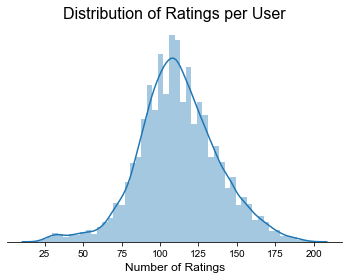

In [11]:
# check user ratings distribution per user
sns.distplot(ratings.user_id.value_counts());
sns.set_style('white')
sns.despine(left=True)
plt.title('Distribution of Ratings per User', fontsize=16)
plt.yticks([])
plt.xlabel('Number of Ratings', fontsize=12)
plt.show();

In [12]:
print(f'The mean number of ratings by user is {ratings.user_id.value_counts().mean()}')
print(f'The median number of ratings by user is {ratings.user_id.value_counts().median()}')
print(f'The maximum number of ratings by user is {ratings.user_id.value_counts().max()}')
print(f'The minimum number of ratings by user is {ratings.user_id.value_counts().min()}')

The mean number of ratings by user is 111.86880428271938
The median number of ratings by user is 111.0
The maximum number of ratings by user is 200
The minimum number of ratings by user is 19


When it comes to how many books each user has rated, we have a very close to normal distribution, with the mean and median very close. Each of our unique users has rated at least 19 books, and a maximum of 200 books. Let's have a look now at how many users have rated each of the 10,000 books we have in our dataset. 

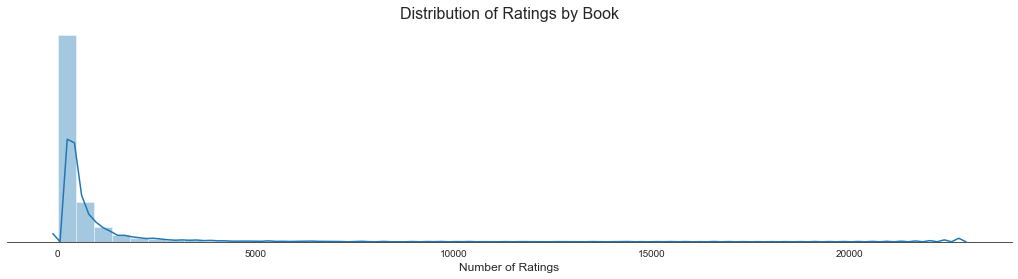

In [13]:
# check ratings distribution per book
plt.figure(figsize=(18,4))
sns.distplot(ratings.book_id.value_counts());
sns.set_style('white')
sns.despine(left=True)
plt.title('Distribution of Ratings by Book', fontsize=16)
plt.yticks([])
plt.xlabel('Number of Ratings', fontsize=12)
plt.show();

In [14]:
print(f'The mean number of ratings per book is {ratings.book_id.value_counts().mean()}.')
print(f'The median number of ratings per book is {ratings.book_id.value_counts().median()}.')
print(f'The maximum number of ratings per book is {ratings.book_id.value_counts().max()}.')
print(f'The minimum number of ratings per book is {ratings.book_id.value_counts().min()}.')

The mean number of ratings per book is 597.6479.
The median number of ratings per book is 248.0.
The maximum number of ratings per book is 22806.
The minimum number of ratings per book is 8.


We see that when it comes to the ratings per book distribution, we have a long tail distribution, which makes perfect sense and is what we expect to encounter in such cases. A few books are very popular with a large number of ratings, while most books have a lower number of ratings. The mean and median number of ratings per book, as well as the great difference between the minimum number and the maximum number of ratings confirms this. Just out of curiosity, let's have a look at which are the books with the most and the least ratings. We will look up the respective book ids at the books metadata dataset.

In [15]:
# get book ids for most ratings and least ratings
ratings.book_id.value_counts()

1       22806
2       21850
4       19088
3       16931
5       16604
        ...  
9315       36
1935       33
9486       24
9345       11
7803        8
Name: book_id, Length: 10000, dtype: int64

In [16]:
books[['book_id','title','authors','ratings_count','average_rating']].loc[books['book_id'].isin([1,2,4,3,5])]

,book_id,title,authors,ratings_count,average_rating
0,1,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,4780653,4.34
1,2,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",4602479,4.44
2,3,"Twilight (Twilight, #1)",Stephenie Meyer,3866839,3.57
3,4,To Kill a Mockingbird,Harper Lee,3198671,4.25
4,5,The Great Gatsby,F. Scott Fitzgerald,2683664,3.89


In [17]:
books[['book_id','title', 'authors','ratings_count',
       'average_rating']].loc[books['book_id'].isin([7803,9345,9486,1935,9315])]

,book_id,title,authors,ratings_count,average_rating
1934,1935,Kindle Paperwhite User's Guide,Amazon,15002,3.72
7802,7803,Kindle User's Guide,Amazon,3508,3.64
9314,9315,The King's Agent,Donna Russo Morin,8250,3.81
9344,9345,Diary ng Panget,"HaveYouSeenThisGirL, Jan Irene Villar",7016,4.40
9485,9486,Fifty Shades Duo: Fifty Shades Darker / Fifty ...,E.L. James,8227,4.41


In [18]:
# check number of books in books metadata dataset
books.book_id.nunique()

10000

In [19]:
# check total number of ratings from books metadata dataframe
books.ratings_count.sum()

540012351

There is some disparity between the number of ratings per book when we compare the ratings dataset to the books metadata set. This means our ratings dataset has a fraction of the total Goodreads users. One option if we could keep working on this project for longer is to do some webscraping to obtain more data from more users to use for our recommendation system, but for the purpose of simplicity we will just work with the number of users that we have now. 

In [20]:
ratings.rating.value_counts()

4    2139018
5    1983093
3    1370916
2     359257
1     124195
Name: rating, dtype: int64

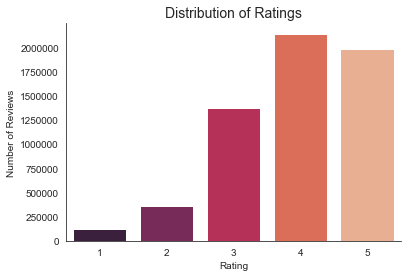

In [21]:
# plot ratings range distribution
count = ratings.rating.value_counts()
count.index
sns.barplot(x=count.index, y=count, palette='rocket')
sns.despine()
plt.title('Distribution of Ratings', fontsize=14)
plt.ylabel('Number of Reviews')  
plt.xlabel('Rating'); 

In [22]:
# check users who give more 5 stars ratings and number of such ratings given by each user
users_most5_ratings = ratings.loc[(ratings.rating == 5)].groupby('user_id').size().sort_values(ascending=False)
users_most5_ratings.head(10)

user_id
53293    194
49288    193
49297    192
49289    192
49295    192
53292    192
50104    189
50133    189
30184    188
50101    187
dtype: int64

In [23]:
# check users who give more 1 star ratings and number of such ratings given by each user
users_most1_ratings = ratings.loc[(ratings.rating == 1)].groupby('user_id').size().sort_values(ascending=False)
users_most1_ratings.head(10)

user_id
44171    167
49586    145
35678    134
51577    130
49660    127
43545    121
52698    117
51328    113
52700    112
38883    110
dtype: int64

In [24]:
# users_by_book = dict()
# for value in ratings.book_id.unique():
#     users_by_book[value] = ratings['user_id'].loc[ratings['book_id'] == value].unique()

In [25]:
# users_by_book[1]

In [26]:
# try to get number of users with 2 or more books reviewed in common 

In [27]:
# check what are the top 10 best rated books
best_rated = books['average_rating'].sort_values(ascending=False)
books[['title', 'authors']].iloc[best_rated.head(10).index]

,title,authors
3627,The Complete Calvin and Hobbes,Bill Watterson
3274,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...","J.K. Rowling, Mary GrandPré"
861,"Words of Radiance (The Stormlight Archive, #2)",Brandon Sanderson
7946,ESV Study Bible,"Anonymous, Lane T. Dennis, Wayne A. Grudem"
8853,Mark of the Lion Trilogy,Francine Rivers
4482,It's a Magical World: A Calvin and Hobbes Coll...,Bill Watterson
421,"Harry Potter Boxset (Harry Potter, #1-7)",J.K. Rowling
6360,There's Treasure Everywhere: A Calvin and Hobb...,Bill Watterson
3752,"Harry Potter Collection (Harry Potter, #1-6)",J.K. Rowling
6919,The Indispensable Calvin and Hobbes,Bill Watterson


There is a lot of love for Calvin and Hobbes and for Harry Potter! Let's check what books are the most disliked ones.

In [28]:
# check what are the top 10 worst rated books
worst_rated = books['average_rating'].sort_values()
books[['title', 'authors']].iloc[worst_rated.head(10).index]

,title,authors
1792,One Night at the Call Center,Chetan Bhagat
3549,The Almost Moon,Alice Sebold
8006,The Finkler Question,Howard Jacobson
9020,Lost,"Gregory Maguire, Douglas Smith"
4008,Four Blondes,Candace Bushnell
8165,Among the Ten Thousand Things,Julia Pierpont
8873,Tell-All,Chuck Palahniuk
4282,Revenge Wears Prada: The Devil Returns (The De...,Lauren Weisberger
4613,The Emperor's Children,Claire Messud
8959,The Red House,Mark Haddon


Well, I'm glad I didn't read any of these! 

In [29]:
# check what are the top 10 books with the most 5 stars ratings
most_5stars = books['ratings_5'].sort_values(ascending=False)
most_5stars = books[['title','authors']].iloc[most_5stars.head(10).index]
most_5stars

,original_title,authors
1,Harry Potter and the Philosopher's Stone,"J.K. Rowling, Mary GrandPré"
0,The Hunger Games,Suzanne Collins
3,To Kill a Mockingbird,Harper Lee
2,Twilight,Stephenie Meyer
24,Harry Potter and the Deathly Hallows,"J.K. Rowling, Mary GrandPré"
5,The Fault in Our Stars,John Green
17,Harry Potter and the Prisoner of Azkaban,"J.K. Rowling, Mary GrandPré, Rufus Beck"
23,Harry Potter and the Goblet of Fire,"J.K. Rowling, Mary GrandPré"
26,Harry Potter and the Half-Blood Prince,"J.K. Rowling, Mary GrandPré"
9,Pride and Prejudice,Jane Austen


In [30]:
# check what are the top 10 books with the most 1 star ratings
most_1star = books['ratings_1'].sort_values(ascending=False)
most_1star = books[['original_title','authors']].iloc[most_1star.head(10).index]
most_1star

,original_title,authors
2,Twilight,Stephenie Meyer
33,Fifty Shades of Grey,E.L. James
7,The Catcher in the Rye,J.D. Salinger
48,"New Moon (Twilight, #2)",Stephenie Meyer
55,Breaking Dawn,Stephenie Meyer
39,"Eat, pray, love: one woman's search for everyt...",Elizabeth Gilbert
27,Lord of the Flies,William Golding
4,The Great Gatsby,F. Scott Fitzgerald
51,Eclipse,Stephenie Meyer
8,Angels & Demons,Dan Brown


In [31]:
# one book is in both top 10 most liked and most disliked - call it a polarizer!
most_5stars.merge(most_1star)

,original_title,authors
0,Twilight,Stephenie Meyer


## Modeling with surprise library

### Memory-based Collaboration Filtering

Let's start with a neighborhood based approach. We will apply a memory-based collaboration filtering model using surprise library. We need to load the dataset into the right format in order to use it with surprise library.

In [32]:
# define reader
reader = Reader(rating_scale=(1, 5))

# load dataframe into correct format for surprise library
data = Dataset.load_from_df(ratings[['user_id', 'book_id', 'rating']], reader)

In [33]:
# check it's the right data type
type(data)

surprise.dataset.DatasetAutoFolds

Here we will split the data to have a training and testing set, and to avoid data leakage.

In [34]:
# Split into train and test set
trainset, testset = train_test_split(data, test_size=0.2, random_state=0)

In [35]:
# check size of test set and have a look at how one sample looks like
print(len(testset))
print(testset[0])

1195296
(36955, 3588, 4.0)


In [36]:
# confirm number of items and users in data
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  53424 

Number of items:  10000 



Because we have more users than books (items), and we saw on our data exploration that on average each item (book) has more ratings by users than each user has items rated, we will approach the problem by calculating item-item similarity. We know that different ways to measure similarity will yield different results. I will try using different similarity metrics  - cosine similarity and pearson correlation - with a basic KNN model and see which performs better .

In [37]:
# define a cosine metric for item-item
sim_cos = {'name':'cosine', 'user_based':False}

In [38]:
# define and fit a basic KNN model with a cosine metric
basic = knns.KNNBasic(sim_options=sim_cos)
basic.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [39]:
# make predictions
predictions = basic.test(testset)

In [40]:
# check accuracy
accuracy.rmse(predictions)

RMSE: 0.8827
0.8827076714825495


The root mean squared error is of .88, which is high when you consider that we are talking about a rating in a range of 1 to 5. Let's see if we get a better model performance by using a pearson correlation metric instead.

In [41]:
# define fit and evaluate a KNN basic model with pearson correlation metric
sim_pearson = {'name':'pearson', 'user_based':False}
basic_pearson = knns.KNNBasic(sim_options=sim_pearson)
basic_pearson.fit(trainset)
predictions = basic_pearson.test(testset)
accuracy.rmse(predictions)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8724
0.87240147717125


The pearson correlation seems to be performing slightly better. Let's now try using this metric with other KNN models that are a little more advanced.

In [42]:
# KNN with means model, which takes the mean ratings of each item into account
sim_pearson = {'name':'pearson', 'user_based':False}
knn_baseline = knns.KNNWithMeans(sim_options=sim_pearson)
knn_baseline.fit(trainset)
predictions = knn_baseline.test(testset)
accuracy.rmse(predictions)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8406
0.8405737196116103


That is a better result. Let's try one more model, a KNN Baseline with a pearson baseline similarity metric.

In [43]:
# KNN baseline model, which takes into account a baseline rating (global mean)
sim_pearson_baseline = {'name': 'pearson_baseline','user_based':False}#'shrinkage':50, 'min_support':5, 
knn_baseline = knns.KNNBaseline(sim_options=sim_pearson)
knn_baseline.fit(trainset)
predictions = knn_baseline.test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8371
0.8370946762161162


We see some further improvement. We can continue to try to further improve on a KNN Baseline by tuning hyperparameters, or we could also look into trying a matrix-factorization approach. Let's do the latter next.

### Model-based Collaboration Filtering

Let's now try a different method, a Matrix Factorization-based approach, with model-based collaboration filtering, to see if it works better with our data. 

In [44]:
# define a base singular value decomposition model
svd = SVD()

# fit and test algorithm
predictions = svd.fit(trainset).test(testset)

# evaluate model
print(accuracy.rmse(predictions))

RMSE: 0.8306
0.8305996583244167


Well, this is already a little bit better than our best neighborhood based model. We can try fine-tuning our hyperparameters with a grid search which could further improve our model performance. I also want to separate part of my data as a validation set, and part as unseen test set, which we will use for our predictions. The method to do this was copied from the surprise library documentation [here](https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-save-some-data-for-unbiased-accuracy-estimation). 

In [47]:
t = time()

raw_ratings = data.raw_ratings

# shuffle ratings
random.shuffle(raw_ratings)

# A = 90% of the data, B = 20% of the data
threshold = int(.8 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

data.raw_ratings = A_raw_ratings  # data is now the set A

# define parameter grid and fit gridsearch on set A data
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005]}
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
grid_search.fit(data)

print(time()-t)

1527.0420701503754


In [51]:
best_svd = grid_search.best_estimator['rmse']

# retrain on the whole set A
trainset = data.build_full_trainset()
best_svd.fit(trainset)

# Compute biased accuracy on A
predictions = best_svd.test(trainset.build_testset())

print('Biased accuracy on A,', end=' ')
accuracy.rmse(predictions)

Biased accuracy on A, RMSE: 0.7786


0.7786288370104011

Great, we were able to achieve some improviment after our grid search. I will save this model so that we can reload it in the future and use it for predictions, without having to run the models again.

In [ ]:
# give file a name
file_name = os.path.expanduser('~/best_svd')

In [53]:
# save best model
dump.dump(file_name, algo=best_svd)

In [55]:
# load saved model
_, saved_svd = dump.load(file_name)

In [113]:
def book_rater(books, num_of_ratings=10):
    user_name = input('Please type in your first name:\n')
    user_id = ratings.user_id.nunique()+1
    rating_list = []
    while num_of_ratings > 0:
        book = books['ratings_count'].sort_values(ascending=False).head(100).index.iloc[np.random.choice(1)]
        print(book[['title','authors']].values)
        rating = input('How do you rate this book on a scale of 1-5? Press n if you have not seen:\n')
        if rating == 'n':
            continue
        else:
            rating_one_book = {'user_id':user_id,'book_id':book['book_id'].values[0],'rating':rating}
            rating_list.append(rating_one_book) 
            num_of_ratings -= 1
    return rating_list 

In [112]:
my_ratings = book_rater(books, 2)

Please type in your first name:Giovanna
[['Holes (Holes, #1)' 'Louis Sachar, Louis Sachar']]
How do you rate this movie on a scale of 1-5? Press n if you have not seen :
n
[['The Curious Incident of the Dog in the Night-Time' 'Mark Haddon']]
How do you rate this movie on a scale of 1-5? Press n if you have not seen :
n
[['Mockingjay (The Hunger Games, #3)' 'Suzanne Collins']]
How do you rate this movie on a scale of 1-5? Press n if you have not seen :
n
[['The Secret Life of Bees' 'Sue Monk Kidd']]
How do you rate this movie on a scale of 1-5? Press n if you have not seen :
4
[['The Secret Life of Bees' 'Sue Monk Kidd']]
How do you rate this movie on a scale of 1-5? Press n if you have not seen :
3
[['The Adventures of Huckleberry Finn'
  'Mark Twain, John Seelye, Guy Cardwell']]
How do you rate this movie on a scale of 1-5? Press n if you have not seen :
3
[['A Wrinkle in Time (A Wrinkle in Time Quintet, #1)' "Madeleine L'Engle"]]
How do you rate this movie on a scale of 1-5? Press n 

In [114]:
my_ratings

[{'user_id': 53425, 'book_id': 57, 'rating': '4'},
 {'user_id': 53425, 'book_id': 57, 'rating': '3'},
 {'user_id': 53425, 'book_id': 58, 'rating': '3'},
 {'user_id': 53425, 'book_id': 117, 'rating': '3'},
 {'user_id': 53425, 'book_id': 95, 'rating': '4'},
 {'user_id': 53425, 'book_id': 17, 'rating': '3'},
 {'user_id': 53425, 'book_id': 34, 'rating': '1'},
 {'user_id': 53425, 'book_id': 66, 'rating': '5'},
 {'user_id': 53425, 'book_id': 71, 'rating': '3'},
 {'user_id': 53425, 'book_id': 35, 'rating': '5'}]

In [132]:
def book_rater(books, num_of_ratings=10):
     '''
    explain function
    '''
    user_name = input('Please type in your first name:\n')
    user_id = ratings.user_id.nunique()+1
    rating_list = []
    while num_of_ratings > 0:
        book = books.loc[books['ratings_count'].sort_values(ascending=False).head(
            100).index].sample(1, random_state=None)
        print(book[['title','authors']].values)
        rating = input('How do you rate this book on a scale of 1-5? Press n if you have not seen:\n')
        if rating == 'n':
            continue
        else:
            rating_one_book = {'user_id':user_id,'book_id':book['book_id'].values[0],'rating':rating}
            rating_list.append(rating_one_book) 
            num_of_ratings -= 1
    return rating_list 

   
    
    def get_recs(df=ratings, num_of_rec=3, num_of_ratings=10):
    '''
    explain function
    '''
    rating_list = book_rater(books, num_of_ratings=num_of_ratings)
    df = pd.DataFrame(rating_list)
    new_ratings_df = ratings.append(df, ignore_index=True)
    new_data = Dataset.load_from_df(new_ratings_df,reader)
    saved_svd.fit(new_data.build_full_trainset())
    testset = trainset.build_anti_testset()
    predictions = saved_svd.predict(testset)
    
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:num_of_rec]
        
    # Print the recommended items for each user
    for uid, user_ratings in top_n.items():
        print(f'{username} recommendations:', books['title','author'].loc[
            books['book_id'].isin([iid for (iid, _) in user_ratings])])

In [ ]:
get_recs()

Please type in your first name:G
[['The Maze Runner (Maze Runner, #1)' 'James Dashner']]
How do you rate this book on a scale of 1-5? Press n if you have not seen :
3
[['Where the Sidewalk Ends' 'Shel Silverstein']]
How do you rate this book on a scale of 1-5? Press n if you have not seen :
3
[['Eclipse (Twilight, #3)' 'Stephenie Meyer']]
How do you rate this book on a scale of 1-5? Press n if you have not seen :
1
[['The Giving Tree' 'Shel Silverstein']]
How do you rate this book on a scale of 1-5? Press n if you have not seen :
5
[['Eclipse (Twilight, #3)' 'Stephenie Meyer']]
How do you rate this book on a scale of 1-5? Press n if you have not seen :
1
[['The Giving Tree' 'Shel Silverstein']]
How do you rate this book on a scale of 1-5? Press n if you have not seen :
5
[['Gone with the Wind' 'Margaret Mitchell']]
How do you rate this book on a scale of 1-5? Press n if you have not seen :
5
[["Harry Potter and the Sorcerer's Stone (Harry Potter, #1)"
  'J.K. Rowling, Mary GrandPré']]


In [ ]:
def get_recs(df=ratings, num_of_rec=3, num_of_ratings=10):
    
    rating_list = book_rater(books, num_of_ratings=num_of_ratings)
    df = pd.DataFrame(rating_list)
    reader = Reader(rating_scale=(1, 5))
    new_data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']],reader)
    predictions = saved_svd.predict(new_data)
    
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:num_of_rec]
        
    # Print the recommended items for each user
    for uid, user_ratings in top_n.items():
        print(f'{username} recommendations:', books['title','author'].loc[
            books['book_id'].isin([iid for (iid, _) in user_ratings])])

In [ ]:
# Compute unbiased accuracy on B
testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
predictions = best_svd.test(testset)
print('Unbiased accuracy on B,', end=' ')
accuracy.rmse(predictions)